# I. Matrix PageRank on Spark



*   Today, we will talk about the iterative version of PageRank.

* We will start with a 'Graph' (which in this case is just a set of edges - 'from' and 'to') and create a Weight Transfer Matrix (WTM). (WTM -> generalized idea of an adjacency matrix to capture the weight and direction of edges).

* At each 'step' of this iterative algorithm, the Page Rank scores would be multiplied with this WTM using numpy/pandas.
*   The issue: Perfect for smaller applcations with less data, but what if the 'Graph' is too big to fit in a numpy/pandas entity or even a single machine? (Ex. Facebook's user-friendship graphs).

* The solution: As we discuss below!




In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=fde27338d7c1233fa05138fb001e1b1011c47ae77d1d2b695e5e8e2559b5677a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Graphs-Rec6').getOrCreate()

In [ ]:
# %%spark

from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry,\
  BlockMatrix

#import pandas as pd
from pyspark.sql.functions import lit


sdf = spark.createDataFrame([{'from': 0, 'to': 1},\
                              {'from': 0, 'to': 2},\
                              {'from': 1, 'to': 2},\
                              {'from': 2, 'to': 0}])


sdf.createOrReplaceTempView('graph')


sdf.show()

+----+---+
|from| to|
+----+---+
|   0|  1|
|   0|  2|
|   1|  2|
|   2|  0|
+----+---+



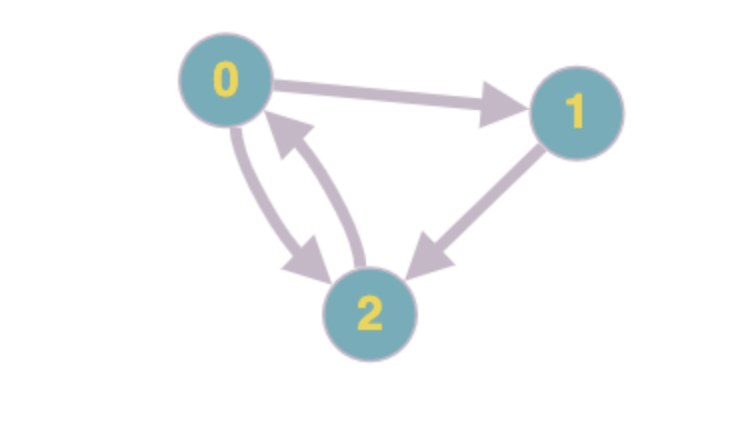

In [ ]:
# %%spark
# Need to create a weight transfer matrix

# Since we have edges, we need to calculate the transfer weights:
# 1) group by the 'from' node (transfer weight 'OUT' from)
# 2) count the number of outgoing edges (c) and then save 1/(c) to propagate (this is the transfer weight)

transfer_weights = spark.sql('''select graph.from as id, 1 / count("to") as weight
                                from graph group by from''')
transfer_weights.show()

Now that we have the weight transfer matrix, join on the (from) edges to compute updated weights. Let's try understanding what this matrix means ...

In [ ]:
# %%spark
weighted_edges = sdf.join(transfer_weights, sdf['from'] == transfer_weights.id)[['from','to','weight']]

# Build matrix M from the weighted edges
M = CoordinateMatrix(weighted_edges.rdd.map(lambda x: MatrixEntry(x[1], x[0], x[2]))).toBlockMatrix()

print (M.toLocalMatrix())

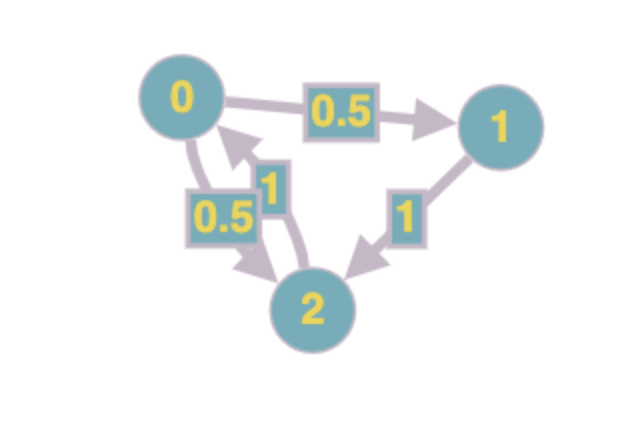

In [ ]:
# %%spark
# Figure out # of nodes for initial page rank
# We'll use all IDs from 0 ... max node ID
sdf1 = sdf[['from']].withColumnRenamed('from', 'id')
sdf2 = sdf[['to']].withColumnRenamed('to', 'id')
sdf_unioned = sdf1.union(sdf2).drop_duplicates()[['id']]
n = sdf_unioned.count()

In [ ]:
# %%spark
PR_sdf = sdf.select(sdf['from'], lit(1 / n).alias('weight')).distinct()
PR = CoordinateMatrix(PR_sdf.rdd.map(lambda x: MatrixEntry(x[0], 0, x[1]))).toBlockMatrix()
print (PR.toLocalMatrix())

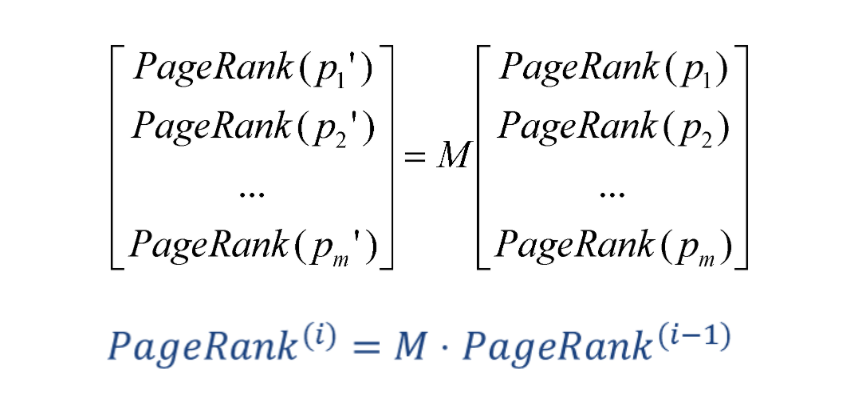

In [ ]:
# %%spark
for i in range(15):
  PR = M.multiply(PR)
  print ('Iteration', i )
  print (PR.toLocalMatrix())

In [ ]:
# %%spark
weighted_edges.take(10)

# II. Breadth-First Search

#### Let's implement the Friends example from the slides and see how it actually works!

#### A graph representation of the Friends table is given below:

In [ ]:
friends_graph = {
  'John' : ['Phillip','Maria'],
  'Phillip' : ['John', 'Carla', 'Ethan'],
  'Maria' : ['John'],
  'Carla' : ['Phillip'],
  'Ethan' : ['Phillip', 'Waldo'],
  'Waldo' : ['Ethan']
}

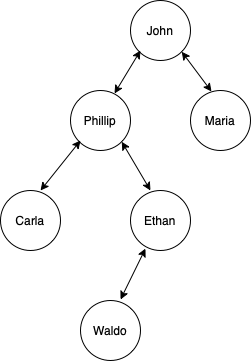

#### TASK: Look at the psuedocode from the Recitation slides, and fill in the TODOs below to complete the BFS implementation.

In [ ]:
def bfs(graph, start_node, target_node):

  # To begin, we create empty lists to store the visited nodes and the queue
  visited = []
  queue = []

  # TODO 1: Mark the start_node as visited by adding it to the visited list
  visited.append(start_node)

  # TODO 2: Add the start_node to the queue list
  queue.append(start_node)

  # We run the loop until the queue becomes empty
  while queue:

    # TODO 3: Remove the first item from the queue list and store it as p
    # Hint: Look at the list .pop() function
    p = queue.pop(0)

    print('Visiting: ' + p)

    # TODO 4: if p is the target_node, break out of the loop
    if p == 'Waldo':
      print('\nFound Waldo!')
      break

    # Now, we look at all the neighbors of p
    for neighbor in graph[p]:

      # TODO 5: if the neighbor is not in visited, add it to visited and queue
      if neighbor not in visited:
        visited.append(neighbor)
        queue.append(neighbor)

#### Let's see if your function is able to find Waldo!

In [ ]:
bfs(friends_graph, 'John', 'Waldo')

Visiting: John
Visiting: Phillip
Visiting: Maria
Visiting: Carla
Visiting: Ethan
Visiting: Waldo

Found Waldo!


# III. Connecting to the AWS EMR Cluster

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev
!pip install sparkmagic

In [ ]:
%%capture
%load_ext sparkmagic.magics

In [ ]:
# TODO: Enter your Master Public DNS with the proper formatting and host

%spark add -s my_session -l python -u http://ec2-34-228-255-193.compute-1.amazonaws.com -a cis545-livy -p recitation6 -t Basic_Access

An error was encountered:
Error sending http request and maximum retry encountered.
